In [16]:
# Enhanced Comparison Analysis - Checkout Visits, Pop-up Modal, and Purchase Events
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns

# Load the CSV file
df = pd.read_csv('analytics.csv')
# Explore the data
print(f"Total records: {len(df)}")
print(f"Event types: {df['type'].unique()}")
print(f"Number of domains: {len(df['domain'].unique())}")
df = df[~df["domain"].isin(['shop.app', 'ticketmaster.dk', 'billetlugen.dk'])]


Total records: 9162
Event types: ['from-directs' 'on-onboarding' 'page-view' 'time-spent'
 'welcome-modal-seen' 'checkout' 'from-directs-cta' 'uninstall'
 'open-popup' 'add-to-cart' 'active' 'enforce_wait_modal_shown'
 'enforce_wait_info_expanded' 'enforce_wait_canceled' 'open-options'
 'questionary-popup']
Number of domains: 39


In [17]:
# Filter for the events we're interested in
page_visits = df[df['type'] == 'page-view']
checkout_events = df[df['type'] == 'checkout']
modal_shown_events = df[df['type'] == 'enforce_wait_modal_shown']

print(f"Page visits: {len(page_visits)}")
print(f"Checkout events: {len(checkout_events)}")
print(f"Modal shown events: {len(modal_shown_events)}")

# Create a dataframe with counts by domain
domain_stats = pd.DataFrame()

# Count page visits by domain
domain_visits = page_visits['domain'].value_counts().reset_index()
domain_visits.columns = ['domain', 'page_visits']

# Count checkout events by domain
domain_checkouts = checkout_events['domain'].value_counts().reset_index()
domain_checkouts.columns = ['domain', 'checkout_events']

# Count modal shown events by domain
domain_modals = modal_shown_events['domain'].value_counts().reset_index()
domain_modals.columns = ['domain', 'modal_shown_events']

# Merge the dataframes
domain_stats = domain_visits.merge(domain_checkouts, on='domain', how='left')
domain_stats = domain_stats.merge(domain_modals, on='domain', how='left')

# Fill NaN values with 0
domain_stats = domain_stats.fillna(0)

# Calculate ratios
domain_stats['checkout_ratio'] = domain_stats['checkout_events'] / domain_stats['page_visits']
domain_stats['modal_ratio'] = domain_stats['modal_shown_events'] / domain_stats['page_visits']

# Display the stats
domain_stats.sort_values('page_visits', ascending=False).head(10)

Page visits: 765
Checkout events: 15
Modal shown events: 8


,domain,page_visits,checkout_events,modal_shown_events,checkout_ratio,modal_ratio
0,amazon.com,145,4.0,0.0,0.027586,0.000000
1,ikea.com,137,1.0,2.0,0.007299,0.014599
2,etsy.com,93,2.0,1.0,0.021505,0.010753
3,walgreens.com,68,1.0,3.0,0.014706,0.044118
4,hm.com,50,1.0,0.0,0.020000,0.000000
5,apple.com,44,1.0,1.0,0.022727,0.022727
6,amazon.de,29,0.0,0.0,0.000000,0.000000
7,shein.com,28,0.0,0.0,0.000000,0.000000
8,matas.dk,26,0.0,0.0,0.000000,0.000000
9,wayfair.com,22,0.0,0.0,0.000000,0.000000


In [18]:
# Filter for domains with sufficient data 
# (at least 10 page visits and at least one checkout or modal event)
min_visits = 10
relevant_domains = domain_stats[
    (domain_stats['page_visits'] >= min_visits) & 
    ((domain_stats['checkout_events'] > 0) | (domain_stats['modal_shown_events'] > 0))
].copy()

print(f"Number of domains with sufficient data: {len(relevant_domains)}")

# Sort by page visits for visualization
relevant_domains = relevant_domains.sort_values('page_visits', ascending=False)

# For visualization, limit to top domains if there are too many
top_n = min(15, len(relevant_domains))
top_domains = relevant_domains.head(top_n)

# Display the filtered domains
top_domains[['domain', 'page_visits', 'checkout_events', 'modal_shown_events', 'checkout_ratio', 'modal_ratio']]

Number of domains with sufficient data: 8


,domain,page_visits,checkout_events,modal_shown_events,checkout_ratio,modal_ratio
0,amazon.com,145,4.0,0.0,0.027586,0.000000
1,ikea.com,137,1.0,2.0,0.007299,0.014599
2,etsy.com,93,2.0,1.0,0.021505,0.010753
3,walgreens.com,68,1.0,3.0,0.014706,0.044118
4,hm.com,50,1.0,0.0,0.020000,0.000000
5,apple.com,44,1.0,1.0,0.022727,0.022727
10,zalando.dk,19,1.0,0.0,0.052632,0.000000
12,zara.com,10,1.0,1.0,0.100000,0.100000


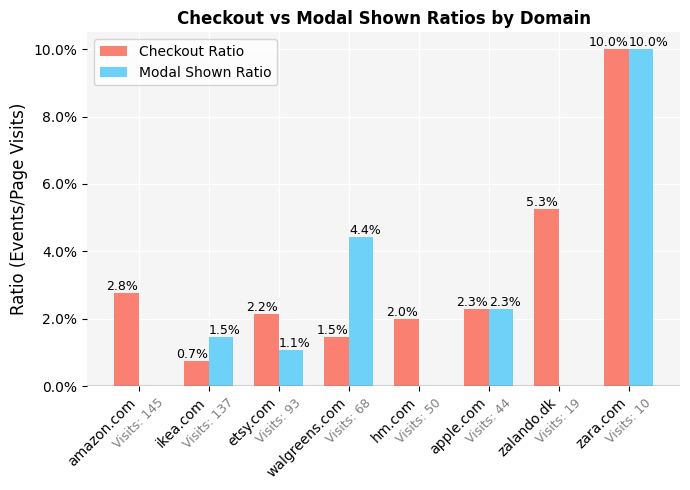

In [19]:
# Set up the visualization style
plt.figure(figsize=(7, 5))

# Create a bar chart for comparison
x = np.arange(len(top_domains))
width = 0.35

# Create the first bar (checkout ratio)
checkout_bars = plt.bar(x - width/2, top_domains['checkout_ratio'], width, label='Checkout Ratio', color='salmon', zorder=2)

# Create the second bar (modal ratio)
modal_bars = plt.bar(x + width/2, top_domains['modal_ratio'], width, label='Modal Shown Ratio', color='#6ED1F8', zorder=2)

# Add labels, title and legend
plt.ylabel('Ratio (Events/Page Visits)', fontsize=12)
plt.title('Checkout vs Modal Shown Ratios by Domain', fontweight='bold')
plt.xticks(x, top_domains['domain'], rotation=45, ha='right')
plt.legend()
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))

# Add domain visit counts as text above the x-axis
for i, domain in enumerate(top_domains['domain']):
    plt.text(i, -0.003, f"Visits: {int(top_domains.iloc[i]['page_visits'])}", 
             ha='center', va='top', rotation=45, fontsize=9, color="gray")

# Add value labels on top of bars
def add_labels(bars, offset=0):
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height) and height > 0:  # Only add label if value is > 0
            extra_offset = 1.8 if 0.08 < height else 1
            plt.text(bar.get_x() + bar.get_width()/2. + offset * extra_offset, height,
                    f'{height:.1%}', ha='center', va='bottom', fontsize=9)

add_labels(checkout_bars, offset=-0.06)
add_labels(modal_bars, offset=0.06)

# Add a horizontal line at y=0
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)


colors = ['salmon', '#F899F3', '#73FABD', '#6ED1F8','#E0F26D', '#106ED3']
ax = plt.gca()
ax.grid(color='white', linewidth=1, axis='y', alpha=1, zorder=1)
ax.grid(color='white', linewidth=1, axis='x', alpha=1, zorder=1)
ax.set_facecolor('#F5F5F5')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Save the plot
plt.savefig('plots/domain_ratio_comparison.png', dpi=300, bbox_inches='tight')
plt.close()

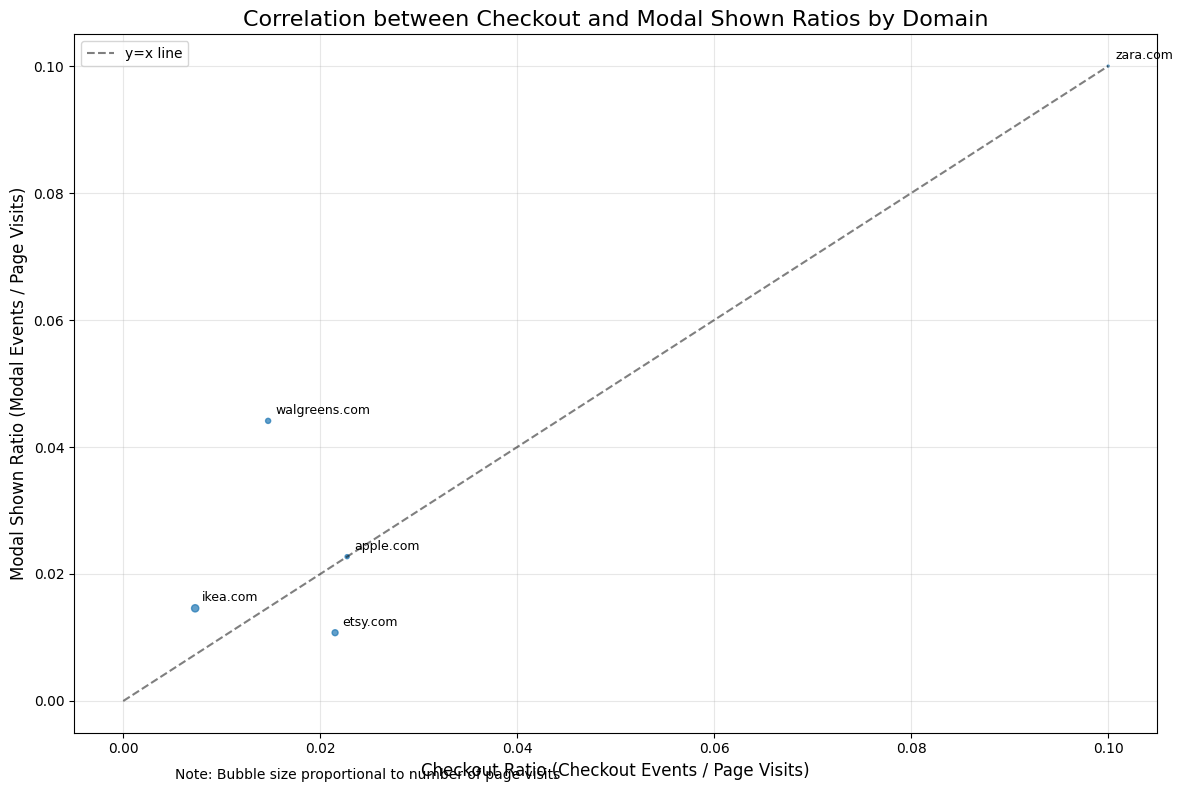

In [20]:
# Create a scatter plot to show the correlation between the two ratios
plt.figure(figsize=(12, 8))

# Filter out domains with zero values in either ratio to focus on meaningful comparisons
plot_data = relevant_domains[(relevant_domains['checkout_ratio'] > 0) & 
                           (relevant_domains['modal_ratio'] > 0)]

# Scatter plot with domain names as annotations
plt.scatter(plot_data['checkout_ratio'], plot_data['modal_ratio'], s=plot_data['page_visits']/5, alpha=0.7)

# Add domain labels to the points
for i, row in plot_data.iterrows():
    plt.annotate(row['domain'], 
                 xy=(row['checkout_ratio'], row['modal_ratio']),
                 xytext=(5, 5), textcoords='offset points',
                 fontsize=9)

# Add a reference line y=x
plt.plot([0, max(plot_data['checkout_ratio'].max(), plot_data['modal_ratio'].max())], 
         [0, max(plot_data['checkout_ratio'].max(), plot_data['modal_ratio'].max())], 
         'k--', alpha=0.5, label='y=x line')

# Add labels and title
plt.xlabel('Checkout Ratio (Checkout Events / Page Visits)', fontsize=12)
plt.ylabel('Modal Shown Ratio (Modal Events / Page Visits)', fontsize=12)
plt.title('Correlation between Checkout and Modal Shown Ratios by Domain', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend()

# Add text explaining the bubble size
plt.figtext(0.15, 0.02, 'Note: Bubble size proportional to number of page visits', fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()

# Save the plot
plt.savefig('plots/domain_ratio_correlation.png', dpi=300, bbox_inches='tight')
plt.close()

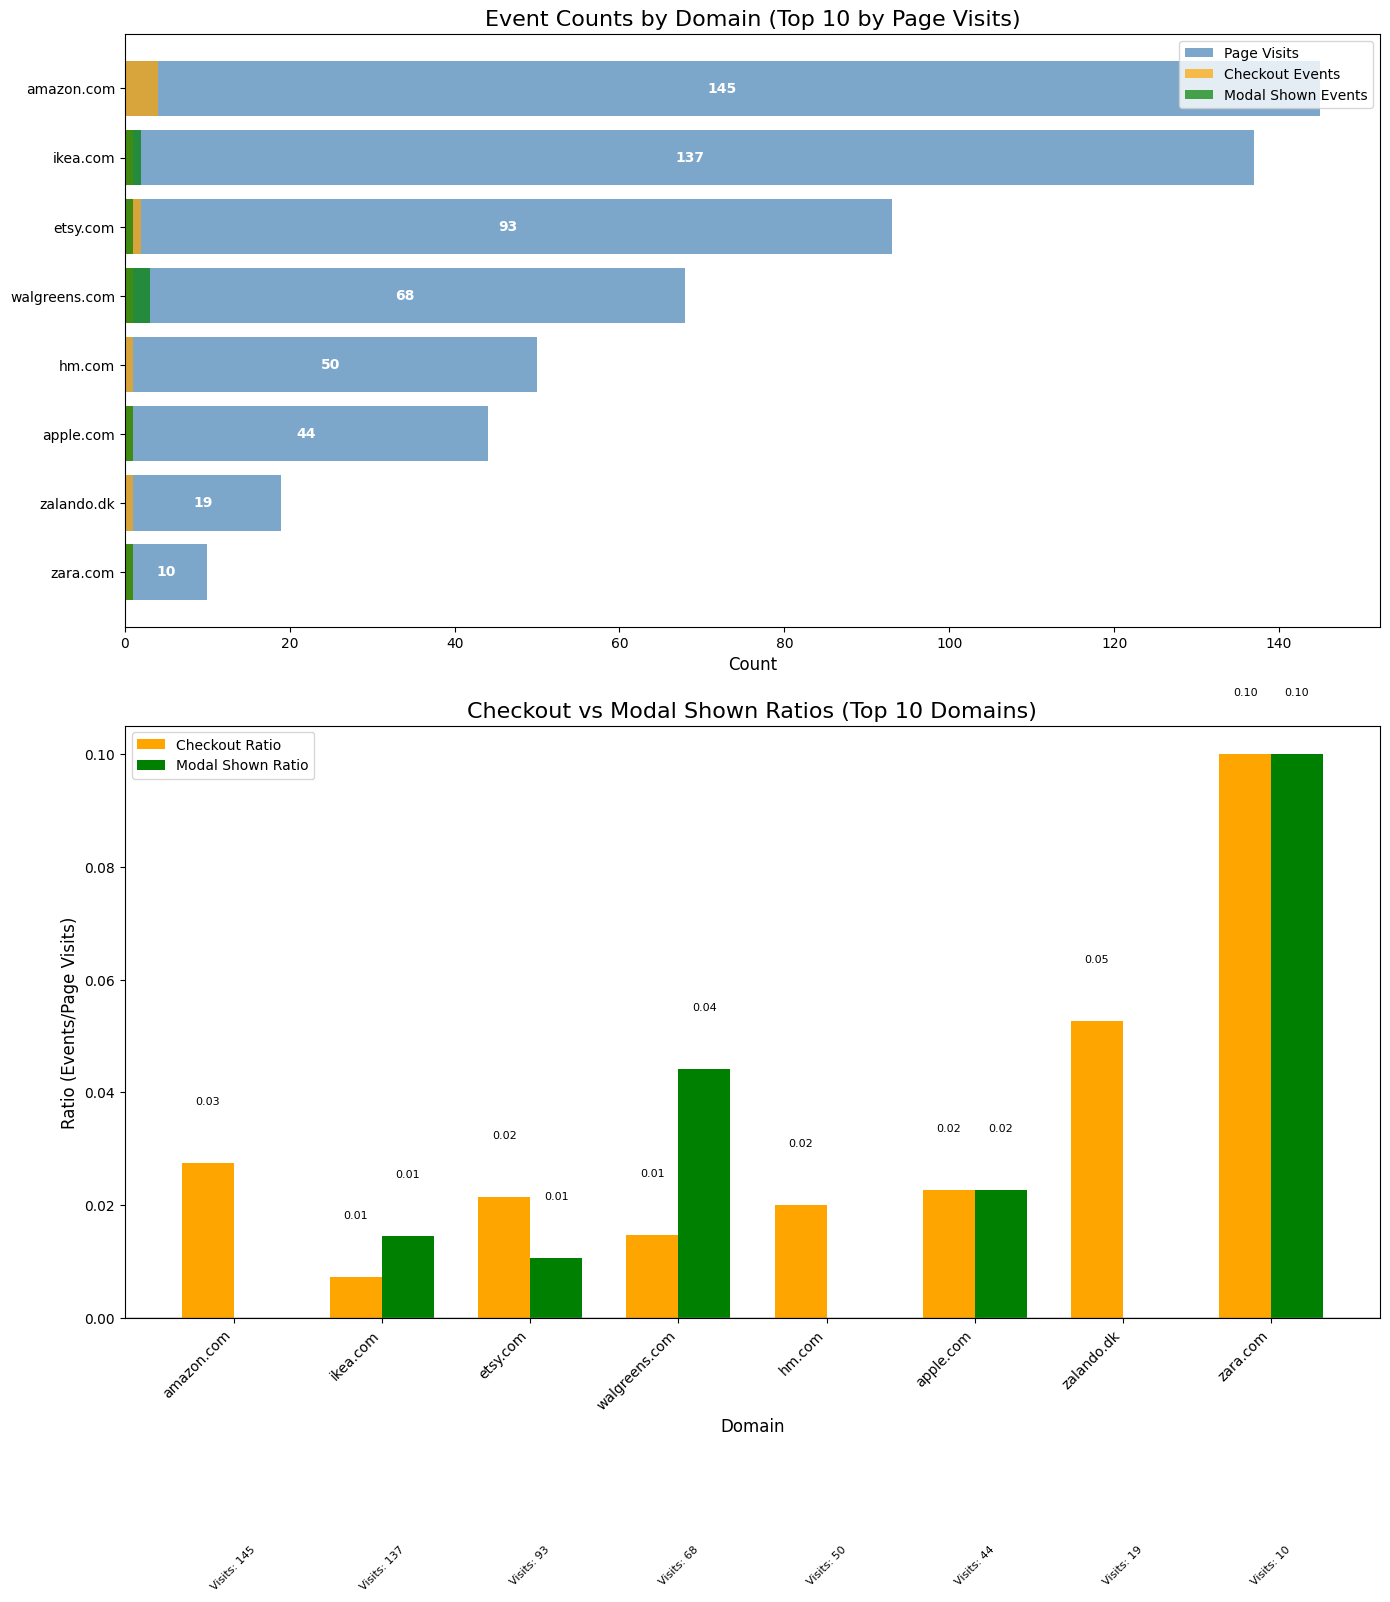

In [21]:
# Create a composite visualization showing counts and ratios
fig, axes = plt.subplots(2, 1, figsize=(14, 16))

# Top 10 domains by page visits
top_10 = relevant_domains.head(10).copy()

# First subplot: Raw counts
ax1 = axes[0]

# Create a stacked bar chart of event counts
top_10.sort_values('page_visits', ascending=True, inplace=True)  # Sort for better visualization
x = np.arange(len(top_10))

# Plot bars
ax1.barh(x, top_10['page_visits'], label='Page Visits', color='steelblue', alpha=0.7)
ax1.barh(x, top_10['checkout_events'], left=0, label='Checkout Events', color='orange', alpha=0.7)
ax1.barh(x, top_10['modal_shown_events'], left=0, label='Modal Shown Events', color='green', alpha=0.7)

# Add domain labels
ax1.set_yticks(x)
ax1.set_yticklabels(top_10['domain'])

# Add count labels inside the bars
for i, domain in enumerate(top_10['domain']):
    # Page visit count
    ax1.text(top_10.iloc[i]['page_visits']/2, i, 
            f"{int(top_10.iloc[i]['page_visits'])}", 
            ha='center', va='center', color='white', fontweight='bold')
    
    # Checkout count (if > 0)
    if top_10.iloc[i]['checkout_events'] > 5:
        ax1.text(2, i - 0.2, 
                f"Checkout: {int(top_10.iloc[i]['checkout_events'])}", 
                ha='left', va='center', fontsize=8)
    
    # Modal count (if > 0)
    if top_10.iloc[i]['modal_shown_events'] > 5:
        ax1.text(2, i + 0.2, 
                f"Modal: {int(top_10.iloc[i]['modal_shown_events'])}", 
                ha='left', va='center', fontsize=8)

# Customize first subplot
ax1.set_title('Event Counts by Domain (Top 10 by Page Visits)', fontsize=16)
ax1.set_xlabel('Count', fontsize=12)
ax1.legend(loc='upper right')

# Second subplot: Ratios
ax2 = axes[1]

# Reset sort order for consistency with previous plots
top_10.sort_values('page_visits', ascending=False, inplace=True)

# Set up data for grouped bar chart
x = np.arange(len(top_10))
width = 0.35

# Create bars
checkout_bars = ax2.bar(x - width/2, top_10['checkout_ratio'], width, label='Checkout Ratio', color='orange')
modal_bars = ax2.bar(x + width/2, top_10['modal_ratio'], width, label='Modal Shown Ratio', color='green')

# Add labels
ax2.set_xlabel('Domain', fontsize=12)
ax2.set_ylabel('Ratio (Events/Page Visits)', fontsize=12)
ax2.set_title('Checkout vs Modal Shown Ratios (Top 10 Domains)', fontsize=16)
ax2.set_xticks(x)
ax2.set_xticklabels(top_10['domain'], rotation=45, ha='right')
ax2.legend()

# Add horizontal line at y=0
ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.3)

# Add value labels on top of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height) and height > 0:  # Only add label if value is > 0
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=8)

add_labels(checkout_bars)
add_labels(modal_bars)

# Display visit counts beneath domain names
for i, count in enumerate(top_10['page_visits']):
    ax2.text(i, -0.04, f"Visits: {int(count)}", ha='center', va='top', fontsize=8, rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

# Save the composite plot
plt.savefig('plots/domain_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
plt.close()

## Analysis Summary

The visualizations above show the comparison between two important ratios across different domains:

1. **Checkout Ratio** - The proportion of page visits that result in users reaching the checkout page
2. **Modal Shown Ratio** - The proportion of page visits that trigger the modal to be shown

These ratios help us understand:
- Which domains have higher checkout conversion rates
- How frequently the intervention modal is shown relative to page visits
- The relationship between checkout behavior and modal interventions

Key insights to look for:
- Domains where checkout ratio is high but modal ratio is low (potential missed intervention opportunities)
- Domains where modal ratio is high but checkout ratio is low (potential effective interventions)
- Correlation between the two ratios across different domains

In [7]:
# Calculate correlation statistics

# For domains with both checkout and modal events
valid_domains = relevant_domains[
    (relevant_domains['checkout_events'] > 0) & 
    (relevant_domains['modal_shown_events'] > 0)
]

# Calculate Pearson and Spearman correlations
if len(valid_domains) > 1:  # Need at least 2 points for correlation
    pearson_corr = valid_domains['checkout_ratio'].corr(valid_domains['modal_ratio'], method='pearson')
    spearman_corr = valid_domains['checkout_ratio'].corr(valid_domains['modal_ratio'], method='spearman')
    
    print(f"Pearson correlation between checkout ratio and modal ratio: {pearson_corr:.3f}")
    print(f"Spearman correlation between checkout ratio and modal ratio: {spearman_corr:.3f}")
    
    # Calculate average ratios
    avg_checkout_ratio = valid_domains['checkout_ratio'].mean()
    avg_modal_ratio = valid_domains['modal_ratio'].mean()
    
    print(f"\nAverage checkout ratio across domains: {avg_checkout_ratio:.3f}")
    print(f"Average modal shown ratio across domains: {avg_modal_ratio:.3f}")
    print(f"Ratio of averages (checkout/modal): {avg_checkout_ratio/avg_modal_ratio if avg_modal_ratio > 0 else 'N/A'}")
else:
    print("Insufficient data for correlation analysis")

Pearson correlation between checkout ratio and modal ratio: 0.920
Spearman correlation between checkout ratio and modal ratio: 0.300

Average checkout ratio across domains: 0.033
Average modal shown ratio across domains: 0.038
Ratio of averages (checkout/modal): 0.8639110724139145
